In [1]:
%matplotlib inline
import pandas as pd
from models.game import Game
from solver import Solver
from tqdm import tqdm
from random import uniform, choice
from models.tile import Tile

In [2]:
game = Game()
game.random_hand()
assert len(game.player_hand_up) == 16
print(", ".join([tile.name for tile in game.player_hand_up]))

solver = Solver(game)
forecast = solver.forecast()
forecast.round(2)

WEST, BAMBOO_3, BAMBOO_5, BAMBOO_6, BAMBOO_7, BAMBOO_7, BAMBOO_8, DOT_2, DOT_6, DOT_8, DOT_9, CHARACTER_2, CHARACTER_2, CHARACTER_4, CHARACTER_6, CHARACTER_9


,tile_add,tile_remove,best_triple_combo,best_double_combo,p,best_triple_combo_p,best_double_combo_p,victory_score
0,BAMBOO_4,None,3,3,3.33,1.67,1.25,1.67
1,BAMBOO_9,CHARACTER_4,3,2,3.33,1.67,0.83,1.67
2,DOT_7,DOT_6,3,3,3.33,1.67,1.25,1.67
3,DOT_7,DOT_9,3,3,3.33,1.67,1.25,1.67
4,DOT_7,CHARACTER_4,3,3,3.33,1.67,1.25,1.67
...,...,...,...,...,...,...,...,...
491,DOT_3,CHARACTER_2,1,1,3.33,0.56,0.42,0.56
492,DOT_4,CHARACTER_2,1,1,3.33,0.56,0.42,0.56
493,DOT_5,CHARACTER_2,1,1,3.33,0.56,0.42,0.56
494,CHARACTER_1,CHARACTER_2,1,1,3.33,0.56,0.42,0.56


100%|██████████| 120/120 [02:26<00:00,  1.22s/it]


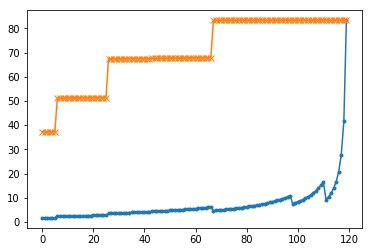

In [3]:

best_chances = []
total_chances = []
last_forecast = forecast.copy()
N = len(solver.game.deck)
path = []
for _ in tqdm(range(N)):
    idx_valid = last_forecast.tile_remove.notna()
    if idx_valid.sum() > 0:
        last_forecast = last_forecast[idx_valid].reset_index(drop=True)
    max_victory_score = last_forecast.victory_score.max()
    total_victory_score = last_forecast.groupby("tile_add")["victory_score"].max().sum()
    p = pd.Series(solver.game.deck).value_counts()
    tile = p.sample(weights=p).keys().item()
    tile_remove = None
    best_tiles_to_remove = []
    solver.game.down_tile(tile)
    best_tiles_to_add = (
        last_forecast[last_forecast.victory_score == max_victory_score][
            "tile_add"
        ]
        .dropna()
        .unique()
    )
    took_tile = False
    if tile.name in best_tiles_to_add:
        best_tiles_to_remove = (
            last_forecast[
                (last_forecast.victory_score == max_victory_score)
                & (last_forecast.tile_add == tile.name)
            ]["tile_remove"]
            .dropna()
            .unique()
        )
        if len(best_tiles_to_remove) > 0:
            tile_remove = Tile[choice(best_tiles_to_remove)]
            solver.game.take_tile(tile, tile_remove)
            took_tile = True
    step = {
        "tile_add": tile.name,
        "tile_remove": tile_remove if took_tile else None,
        "best_tiles_to_add": ", ".join(best_tiles_to_add),
        "best_tiles_to_remove": ", ".join(best_tiles_to_remove) if took_tile else None,
        "took_tile": took_tile,
        "max_victory_score": max_victory_score,
        "total_victory_score": total_victory_score,
    }
    path.append(step)
    last_forecast = solver.forecast()
    best_chances.append(max_victory_score)
    total_chances.append(total_victory_score)
pd.Series(best_chances).plot.line(marker=".")
pd.Series(total_chances).plot.line(marker="x")
pd.DataFrame(path).to_csv("path.csv", index=False)
